In [20]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 17 14:42:23 2018

@author: jrwangzhanguo
"""

'\nCreated on Wed Jan 17 14:42:23 2018\n\n@author: jrwangzhanguo\n'

In [21]:
import numpy as np
import pandas as pd
import math as m
import time as t
from hmmlearn import hmm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from cvxopt import matrix, solvers
import warnings
warnings.filterwarnings("ignore")

# 数据处理及相关函数定义

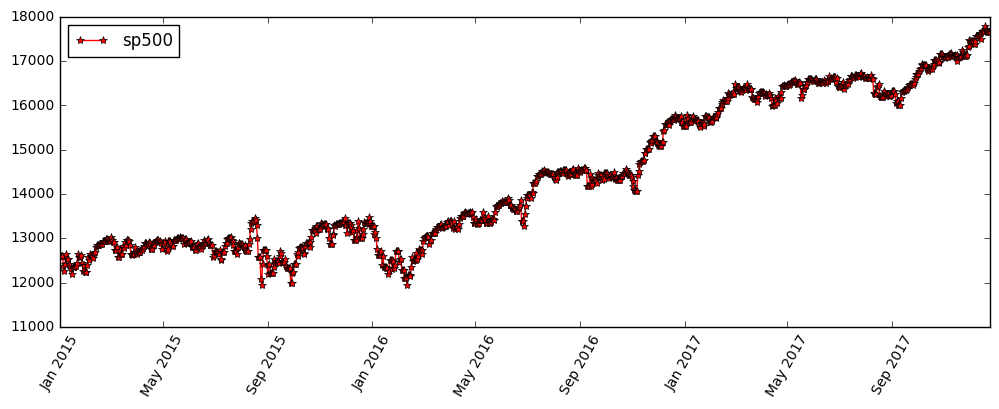

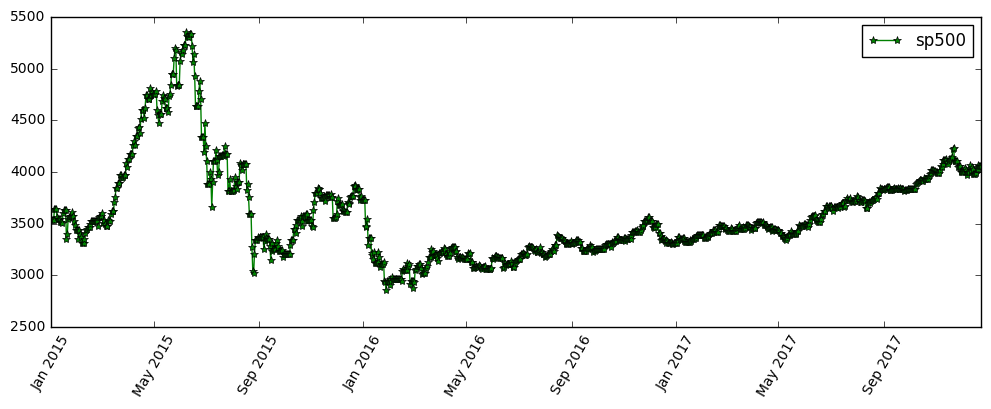

In [22]:
#设置随机种子
np.random.seed(3)

#定义放缩数据函数
def rolling_function(DF, n_length):
    DF = ((DF/DF.rolling(window = n_length).mean())-1)*100
    DF = DF.dropna(axis = 0)
    return DF

#定义日期处理函数
def date_handle(DF, n_length):
    DF_HL = DF
    DF_HL.reset_index(inplace = True)
    DF_HL = DF_HL.drop(range(n_length-1), axis = 0)
    DF_HL = DF_HL.drop('index', axis = 1)
    DF = DF.drop('index', axis  = 1)
    return DF_HL, DF

#计算最大回撤
def max_down(array):
    max_drawdown = 0
    for i in array.index[1:]:
        down = np.abs((array[i]- np.max(array[:i]))/np.max(array[:i]))
        if max_drawdown<down:
            max_drawdown = down
    return max_drawdown

#读入数据
MRS_DATA = pd.read_excel("D:/data/MRS_DATA_20171228/MRS_OR_DATA.xlsx", sheetname = 'yield')    #收益率数据
VALUE_DATA = pd.read_excel("D:/data/MRS_DATA_20171228/MRS_OR_DATA.xlsx", sheetname = 'value')   #净值数据

plt.figure(figsize=(12, 4))
plt.plot_date((VALUE_DATA[VALUE_DATA['net_date'] >= '2015-01-01'])['net_date'],(VALUE_DATA[VALUE_DATA['net_date'] >= '2015-01-01'])['sp_500_value'], '-*', label ="sp500", color = 'red')
plt.legend(loc = "best")
plt.xticks(rotation=60)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot_date((VALUE_DATA[VALUE_DATA['net_date'] >= '2015-01-01'])['net_date'],(VALUE_DATA[VALUE_DATA['net_date'] >= '2015-01-01'])['csi_300_value'], '-*', label ="sp500", color = 'green')
plt.legend(loc = "best")
plt.xticks(rotation=60)
plt.show()

#处理净值信息
VALUE_DATA['month'] = list(VALUE_DATA['net_date'][i].month for i in MRS_DATA.index)
VALUE_DATA['year'] = list(VALUE_DATA['net_date'][i].year for i in MRS_DATA.index)
VALUE_DATA['day'] = list(VALUE_DATA['net_date'][i].day for i in MRS_DATA.index)
VALUE_DATA = VALUE_DATA.drop('net_date', axis = 1)
#按每月日期排序，挑选每月最后一天的指数当做本月指数
VALUE_DATA['sort_id'] = VALUE_DATA['day'].groupby([VALUE_DATA['year'], VALUE_DATA['month']]).rank(ascending = False, method = 'dense')
VALUE_MONTH_DATA = VALUE_DATA[VALUE_DATA['sort_id'] == 1.0]
VALUE_MONTH_DATA['date'] = list(t.strftime("%Y-%m", (VALUE_MONTH_DATA['year'][i],VALUE_MONTH_DATA['month'][i],1,0,0,0,0,0,0)) for i in VALUE_MONTH_DATA.index)
VALUE_MONTH_DATA = VALUE_MONTH_DATA.drop(['year','month','day','sort_id','monetary_fund_value'], axis = 1)

#设置标准化滑动窗口窗宽
n_length = 3

#原始数据与标准化数据选取相同时间段
VALUE_OR_DATA, VALUE_MONTH_DATA = date_handle(VALUE_MONTH_DATA, n_length)
VALUE_OR_DATA.set_index('date', inplace = True)

#原始数据训练集与测试集划分，保存的是净值数据
train_or_set = VALUE_OR_DATA[VALUE_OR_DATA.index < '2014-12-31']
test_or_set = VALUE_OR_DATA[VALUE_OR_DATA.index > '2014-12-30']

#标准化处理，用月末指数除以前4月指数平均价
VALUE_MONTH_DATA.set_index('date', inplace = True)
VALUE_MONTH_DATA = rolling_function(VALUE_MONTH_DATA, n_length)


#放缩后的训练集与测试集划分，保存的是滚动处理后的净值数据
VALUE_train_set = VALUE_MONTH_DATA[VALUE_MONTH_DATA.index < '2014-12-31']
VALUE_test_set = VALUE_MONTH_DATA[VALUE_MONTH_DATA.index > '2014-12-30']

# 使用训练集训练MRS模型参数，并应用在测试集上预测各资产收益率及波动率

In [23]:
#利用马尔科夫模型计算状态转移概率
#设置隐藏状态数量
components = 5
HMM_Model = hmm.GaussianHMM(n_components = components)
HMM_result = HMM_Model.fit(VALUE_train_set)


print ("HMM_result's means is: \n", HMM_result.means_)                #打印状态均值
print ("HMM_result's convars is: \n", HMM_result.covars_)             #状态方差协方差
print ("HMM_result's transmat is: \n", HMM_result.transmat_)          #打印状态转移矩阵

HMM_result's means is: 
 [[ 0.46300954  1.54937241  1.79716962 -1.54471437]
 [ 0.40443954 -2.79477    -1.15775657  2.45748821]
 [ 0.02610328 11.90809733  3.83080243  0.84729161]
 [-0.08763191  0.08381773  2.4532017   3.7982806 ]
 [ 0.60859392 -6.64277142 -2.47516283 -3.12362729]]
HMM_result's convars is: 
 [[[ 0.36437606  0.          0.          0.        ]
  [ 0.         13.20603579  0.          0.        ]
  [ 0.          0.          2.00625147  0.        ]
  [ 0.          0.          0.          5.09893764]]

 [[ 0.37275667  0.          0.          0.        ]
  [ 0.         10.13766548  0.          0.        ]
  [ 0.          0.          8.26056857  0.        ]
  [ 0.          0.          0.         13.5388786 ]]

 [[ 0.16156466  0.          0.          0.        ]
  [ 0.         24.28145781  0.          0.        ]
  [ 0.          0.          9.29540182  0.        ]
  [ 0.          0.          0.          2.59177897]]

 [[ 0.43922007  0.          0.          0.        ]
  [ 0.    

In [24]:
#统计状态信息，打印内个状态的统计数量
train_pred = HMM_result.predict(VALUE_train_set)
train_pred_prob = HMM_result.predict_proba(VALUE_train_set)
#train_sort_pred = list(train_pred)

#测试集上的状态预测信息，需要根据需要根据上一月状态来预测下一月可能出现状态概率，每一个特征集后面对应标签为预测的前一月状态
test_pred_initial = HMM_result.predict(VALUE_test_set) 
test_pred_initial_prob = HMM_result.predict_proba(VALUE_test_set)   
test_pred = HMM_result.predict(VALUE_test_set)
test_pred = np.append(np.array(train_pred[len(train_pred)-1]), test_pred)
test_pred = np.delete(test_pred,len(test_pred)-1,axis=0)
#输出个时期的状态预测概率。需要根据需要根据上一月状态来预测下一月可能出现状态概率，每一个特征集后面对应标签为预测的前一月状态概率
test_pred_prob = HMM_result.predict_proba(VALUE_test_set)
test_pred_prob = np.append(np.array(train_pred_prob[len(train_pred)-1]), test_pred_prob)
test_pred_prob = test_pred_prob.reshape(len(test_pred)+1,components)
test_pred_prob = np.delete(test_pred_prob,len(test_pred),axis=0)


month = list(MRS_DATA['net_date'][i].month for i in MRS_DATA.index)
year = list(MRS_DATA['net_date'][i].year for i in MRS_DATA.index)
MRS_DATA = MRS_DATA.drop(['net_date'], axis = 1)
MRS_DATA = (np.log(MRS_DATA+1))
MRS_DATA['month'] = month
MRS_DATA['year'] = year
MRS_MONTH_DATA = pd.DataFrame(np.exp(MRS_DATA.groupby(['year','month']).sum()))-1    #计算每月累计收益
MRS_MONTH_DATA = MRS_MONTH_DATA.reset_index()
MRS_MONTH_DATA['date'] = list(t.strftime("%Y-%m", (MRS_MONTH_DATA['year'][i],MRS_MONTH_DATA['month'][i],1,0,0,0,0,0,0)) for i in MRS_MONTH_DATA.index)
monetary_fund_test_yield =  (MRS_MONTH_DATA[MRS_MONTH_DATA['date'] > '2014-12-30'])['monetary_fund_yield']   #记录货币型基金的在测试集每月收益
monetary_mean_yield = MRS_MONTH_DATA['monetary_fund_yield'][0:72].mean()          #记录货币型基金在训练集上平均收益
monetary_fund_std = MRS_MONTH_DATA['monetary_fund_yield'][0:72].std()     #记录货币型基金在训练集上平标准差
MRS_MONTH_DATA = MRS_MONTH_DATA.drop(['year', 'month', 'monetary_fund_yield'], axis = 1)   #保存每月累计收益


MRS_MONTH_DATA, backup = date_handle(MRS_MONTH_DATA, n_length)    #除去计算均值消耗的前4月
MRS_MONTH_DATA.set_index('date', inplace = True)
MRS_train = MRS_MONTH_DATA[MRS_MONTH_DATA.index < '2014-12-31']
MRS_test = MRS_MONTH_DATA[MRS_MONTH_DATA.index > '2014-12-30']

MRS_train_set = MRS_train*100
MRS_test_set = MRS_test*100
MRS_test_set['last_month_state'] = test_pred



#共3维，第一位维度为隐藏状态，第二个维度为资产种类，第三个维度为时间
#生成数据包括原始收益数据，每个状态下每个资产的收益均值，个状态下每个资产的收益波动率，各状态下每个资产的收益-均值数据，以及ADF平稳性检验结果
#此步骤保存的均为训练集数据
STATA_DATA = list()
STATA_MEAN = list()
STATE_STAND = list()
STATE_STD = list() 
for i in range(HMM_result.n_components):
    pos = (train_pred == i)
    asset = list()
    mean_data = list()
    stand = list()
    std_data = list()
    for j in MRS_train_set.columns:
        asset.append(MRS_train_set[j][pos])
        mean_data.append(MRS_train_set[j][pos].mean())
        std_data.append(MRS_train_set[j][pos].std())
        stand.append(MRS_train_set[j][pos]-MRS_train_set[j][pos].mean())
    STATA_DATA.append(asset)       #保存资产原始数据，每行代表一种状态，每列代表一种资产
    STATA_MEAN.append(mean_data)   #当用均值代替状态收益时，仅需要每种状态的平均收益
    STATE_STD.append(std_data)     #保存训练集的每种状态标准差
    STATE_STAND.append(stand)      #保存训练标准化后数据


STATA_MEAN = np.array(STATA_MEAN)
STATE_STD = np.array(STATE_STD)

#计算下一月的期望收益，用根据上一期的预测状态后的转移概率向量乘各状态下各资产的平均收益矩阵即可
pre_profit = list()
pre_std = list()
for i in range(len(MRS_test_set.index)):
    state_prob = test_pred_prob[i].dot(np.array(HMM_result.transmat_))
    profit = state_prob.dot(STATA_MEAN)
    std = state_prob.dot(STATE_STD)
    pre_profit.append(profit)
    pre_std.append(std)
profit_predict = pd.DataFrame(pre_profit,columns=('csi_quan_zhai_yield', 'csi_300_yield', 'sp_500_yield', 'shanghai_gold_yield'))
std_predict = pd.DataFrame(pre_std,columns=('csi_quan_zhai_yield', 'csi_300_yield', 'sp_500_yield', 'shanghai_gold_yield'))
MRS_test_set['monetary_fund_yield'] = list(monetary_fund_test_yield*100)
profit_predict['monetary_fund_yield'] = np.ones(len(profit_predict.index))*monetary_mean_yield*100
std_predict['monetary_fund_yield'] = np.ones(len(std_predict.index))*monetary_fund_std*100   #由于是标准差而不是方差，故乘100即可

#除以100变为原始收益数据
MRS_test_set = MRS_test_set/100
profit_predict = profit_predict/100
std_predict = std_predict/100
#根绝标准差计算方差
for i in std_predict.columns:
    std_predict[i] = std_predict[i]*std_predict[i]

print('资产收益预测为：\n', profit_predict.head(5))

资产收益预测为：
    csi_quan_zhai_yield  csi_300_yield  sp_500_yield  shanghai_gold_yield  \
0            -0.001088       0.112173      0.045091             0.014622   
1            -0.001109       0.113018      0.045265             0.014528   
2             0.000071       0.070917      0.035953             0.017255   
3             0.001159       0.067145      0.030706             0.004559   
4             0.001162       0.060644      0.030073             0.007342   

   monetary_fund_yield  
0             0.002646  
1             0.002646  
2             0.002646  
3             0.002646  
4             0.002646  


# 根据预测收益和方差，使用CAPM模型求解资产配比

In [25]:
def max_profit_diff_vol(profit_predict_vector, std_predict_vector, punish):
    Q = matrix(punish * np.diag(std_predict_vector))
    p = matrix((-1.0)*profit_predict_vector)
    G = matrix(np.diag(np.ones(5)*(-1)))
    h = matrix(np.zeros(5))
    A = matrix(np.ones(5),(1,5))
    b = matrix(1.0)
    return solvers.qp(Q,p,G,h,A,b)['x']

def weight_cul(profit_predict, std_predict, punish):
    Weight_Matrix = list()
    for i in profit_predict.index:
        weight = max_profit_diff_vol(np.array(profit_predict.loc[i]), np.array(std_predict.loc[i]), punish)
        Weight_Matrix.append(list(weight))
    
    Weight_Matrix = np.array(Weight_Matrix)
    Weight_Matrix = pd.DataFrame(Weight_Matrix,columns=('csi_quan_zhai_weight', 'csi_300_weight', 'sp_500_weight', 'shanghai_gold_weight','monetary_fund_weight'))
    
    return Weight_Matrix
    

weight_no_punished = weight_cul(profit_predict, std_predict, punish = 0)
weight_5_punished = weight_cul(profit_predict, std_predict, punish = 5)
weight_10_punished = weight_cul(profit_predict, std_predict, punish = 10)
weight_20_punished = weight_cul(profit_predict, std_predict, punish = 20)
weight_50_punished = weight_cul(profit_predict, std_predict, punish = 50)
weight_100_punished = weight_cul(profit_predict, std_predict, punish = 100)

print('对方差施加100惩罚下的资产的配资为：\n', weight_100_punished.head(5))

     pcost       dcost       gap    pres   dres
 0: -4.3510e-02 -1.1122e+00  1e+00  6e-17  3e+00
 1: -4.7257e-02 -1.2217e-01  7e-02  7e-17  2e-01
 2: -1.0737e-01 -1.3674e-01  3e-02  3e-16  4e-02
 3: -1.1194e-01 -1.1242e-01  5e-04  1e-16  7e-04
 4: -1.1217e-01 -1.1218e-01  5e-06  1e-16  7e-06
 5: -1.1217e-01 -1.1217e-01  5e-08  4e-19  7e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3831e-02 -1.1130e+00  1e+00  1e-16  3e+00
 1: -4.7640e-02 -1.2302e-01  8e-02  8e-17  2e-01
 2: -1.0818e-01 -1.3765e-01  3e-02  2e-16  4e-02
 3: -1.1278e-01 -1.1326e-01  5e-04  3e-16  7e-04
 4: -1.1302e-01 -1.1302e-01  5e-06  6e-16  7e-06
 5: -1.1302e-01 -1.1302e-01  5e-08  1e-16  7e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.8777e-02 -1.0709e+00  1e+00  1e-16  3e+00
 1: -3.0153e-02 -8.0917e-02  5e-02  7e-17  1e-01
 2: -6.9748e-02 -8.7971e-02  2e-02  1e-16  2e-02
 3: -7.0850e-02 -7.1087e-02  2e-04  1e-16  3e-04
 4: -7.0916e-02 -7.0919e

 2: -3.8535e-03 -7.3318e-03  3e-03  8e-17  7e-03
 3: -5.5591e-03 -6.0551e-03  5e-04  1e-16  1e-04
 4: -5.8673e-03 -5.9088e-03  4e-05  1e-16  4e-18
 5: -5.8914e-03 -5.8934e-03  2e-06  1e-16  1e-17
 6: -5.8932e-03 -5.8932e-03  2e-08  2e-16  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.5073e-04 -1.0083e+00  1e+00  8e-17  3e+00
 1: -6.7205e-04 -1.8226e-02  2e-02  7e-17  5e-02
 2: -3.6187e-03 -6.8385e-03  3e-03  7e-17  7e-03
 3: -5.2192e-03 -5.7596e-03  5e-04  6e-17  6e-04
 4: -5.6078e-03 -5.6451e-03  4e-05  1e-16  7e-18
 5: -5.6331e-03 -5.6343e-03  1e-06  1e-16  4e-18
 6: -5.6341e-03 -5.6341e-03  1e-08  4e-16  1e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.1852e-04 -1.0082e+00  1e+00  2e-16  3e+00
 1: -6.4122e-04 -1.8182e-02  2e-02  9e-17  5e-02
 2: -3.6051e-03 -6.8003e-03  3e-03  1e-16  7e-03
 3: -5.1999e-03 -5.7405e-03  5e-04  2e-16  6e-04
 4: -5.5918e-03 -5.6284e-03  4e-05  1e-16  2e-18
 5: -5.6168e-03 -5.6180

 3: -1.0196e-02 -1.0584e-02  4e-04  9e-17  2e-18
 4: -1.0270e-02 -1.0325e-02  5e-05  8e-17  2e-18
 5: -1.0291e-02 -1.0292e-02  7e-07  1e-16  2e-18
 6: -1.0291e-02 -1.0291e-02  7e-09  1e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.0974e-03 -1.0156e+00  1e+00  8e-17  3e+00
 1: -3.4089e-03 -2.5081e-02  2e-02  6e-17  6e-02
 2: -5.8378e-03 -8.5472e-03  3e-03  1e-16  3e-03
 3: -6.2615e-03 -6.6983e-03  4e-04  1e-16  3e-04
 4: -6.3546e-03 -6.4104e-03  6e-05  2e-17  2e-18
 5: -6.3624e-03 -6.3655e-03  3e-06  6e-17  5e-19
 6: -6.3636e-03 -6.3639e-03  2e-07  2e-16  3e-18
 7: -6.3638e-03 -6.3638e-03  5e-09  1e-16  8e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.4289e-03 -1.0186e+00  1e+00  6e-17  3e+00
 1: -5.8541e-03 -2.8014e-02  2e-02  8e-17  6e-02
 2: -8.8896e-03 -1.2048e-02  3e-03  2e-16  3e-03
 3: -9.5752e-03 -9.9389e-03  4e-04  1e-16  3e-18
 4: -9.6770e-03 -9.7128e-03  4e-05  1e-16  2e-18
 5: -9.6863e-03 -9.6868

# 回测查看在测试集上效果

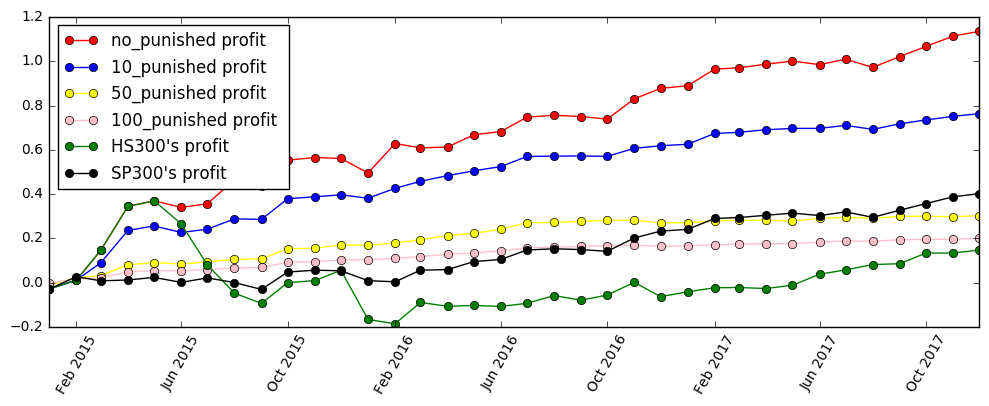

In [26]:
profit_no_punished  =list()
profit_5_punished  =list()
profit_10_punished  =list()
profit_20_punished  =list()
profit_50_punished  =list()
profit_100_punished  =list()
MRS_test_yield = MRS_test_set.copy()
MRS_test_yield.reset_index(inplace = True)
MRS_test_yield = MRS_test_yield.drop(['date', 'last_month_state'], axis = 1)


for i in MRS_test_yield.index:

    profit_no_punished.append(np.array(weight_no_punished.loc[i]).dot(MRS_test_yield.loc[i]))
    profit_5_punished.append(np.array(weight_5_punished.loc[i]).dot(MRS_test_yield.loc[i]))
    profit_10_punished.append(np.array(weight_10_punished.loc[i]).dot(MRS_test_yield.loc[i]))
    profit_50_punished.append(np.array(weight_50_punished.loc[i]).dot(MRS_test_yield.loc[i]))
    profit_100_punished.append(np.array(weight_100_punished.loc[i]).dot(MRS_test_yield.loc[i]))
    

leiji_no_punished  =list()        
leiji_5_punished  =list()
leiji_10_punished  =list()
leiji_50_punished  =list()
leiji_100_punished  =list()
for i in MRS_test_yield.index:
    leiji_no_punished.append(np.product(1+np.array(profit_no_punished[:i+1]))-1)
    leiji_5_punished.append(np.product(1+np.array(profit_5_punished[:i+1]))-1)
    leiji_10_punished.append(np.product(1+np.array(profit_10_punished[:i+1]))-1)
    leiji_50_punished.append(np.product(1+np.array(profit_50_punished[:i+1]))-1)
    leiji_100_punished.append(np.product(1+np.array(profit_100_punished[:i+1]))-1)


time_monetary_profit = list()
time_quan_zhai_profit = list()
time_300_profit = list()
time_500_profit = list()
time_gold_profit = list()

for i in range(len(MRS_test_set)):
    time_monetary_profit.append(np.product(1+np.array(MRS_test_set['monetary_fund_yield'])[:i+1])-1)
    time_quan_zhai_profit.append(np.product(1+np.array(MRS_test_set['csi_quan_zhai_yield'])[:i+1])-1)
    time_300_profit.append(np.product(1+np.array(MRS_test_set['csi_300_yield'])[:i+1])-1)
    time_500_profit.append(np.product(1+np.array(MRS_test_set['sp_500_yield'])[:i+1])-1)
    time_gold_profit.append(np.product(1+np.array(MRS_test_set['shanghai_gold_yield'])[:i+1])-1)


plt.figure(figsize=(12, 4))
plt.plot_date(MRS_test_set.index.values, leiji_no_punished, '-o', label ="no_punished profit ", color = 'red')
plt.plot_date(MRS_test_set.index.values, leiji_10_punished, '-o', label ="10_punished profit ", color = 'blue')
plt.plot_date(MRS_test_set.index.values, leiji_50_punished, '-o', label ="50_punished profit ", color = 'yellow')
plt.plot_date(MRS_test_set.index.values, leiji_100_punished, '-o', label ="100_punished profit ", color = 'pink')
plt.plot_date(MRS_test_set.index.values, time_300_profit, '-o', label ="HS300's profit", color = 'green')
plt.plot_date(MRS_test_set.index.values, time_500_profit, '-o', label ="SP300's profit", color = 'black')
plt.legend(loc = "best")
plt.xticks(rotation=60)
plt.show()   

In [27]:
quant_data = pd.DataFrame()
quant_data['leiji_no_punished'] = leiji_no_punished
quant_data['leiji_10_punished'] = leiji_10_punished
quant_data['leiji_50_punished'] = leiji_50_punished
quant_data['leiji_100_punished'] = leiji_100_punished
quant_data['csi_300_profit'] = time_300_profit
quant_data['sp_500_profit'] = time_500_profit
quant_data = quant_data+1

for j in quant_data.columns:
    quant_data[str(j)+'_yield']=0.0
    for i in range(1, len(quant_data)):
        quant_data[str(j)+'_yield'][i]=np.log(float(quant_data[j][i])/float(quant_data[j][i-1]))    #对数方法求解
    
    R  = quant_data[j][len(quant_data)-1] -  quant_data[j][0]
    R = pow(pow(1+R, 1/(len(quant_data)-1)), 12) - 1
    STD = quant_data[str(j)+'_yield'].std() * np.sqrt(12)
    shape = (R-0.02)/STD
    rt = pow((1+0.02), 1/12)-1
    MAX_DOWN = max_down(quant_data[j])

    print(str(j)+"年化收益率为:", R)
    print(str(j)+"波动率为:", STD)
    print(str(j)+"夏普值为:", (R-0.02)/STD)
    print(str(j)+"最大回撤为:", MAX_DOWN)
    print('\n')

leiji_no_punished年化收益率为: 0.3028128268121324
leiji_no_punished波动率为: 0.1412191366039278
leiji_no_punished夏普值为: 2.0026522864626153
leiji_no_punished最大回撤为: 0.1724627818106792


leiji_10_punished年化收益率为: 0.22124217843345706
leiji_10_punished波动率为: 0.09392933496539053
leiji_10_punished夏普值为: 2.1424848638352154
leiji_10_punished最大回撤为: 0.13381663321715812


leiji_50_punished年化收益率为: 0.09809221037518134
leiji_50_punished波动率为: 0.041259891591126314
leiji_50_punished夏普值为: 1.8926906340194185
leiji_50_punished最大回撤为: 0.04682393127325939


leiji_100_punished年化收益率为: 0.0652499341468955
leiji_100_punished波动率为: 0.020948388802575317
leiji_100_punished夏普值为: 2.16006751513666
leiji_100_punished最大回撤为: 0.025183135619403392


csi_300_profit年化收益率为: 0.05700703845881616
csi_300_profit波动率为: 0.25531601347410643
csi_300_profit夏普值为: 0.1449460139818818
csi_300_profit最大回撤为: 0.4055839199158958


sp_500_profit年化收益率为: 0.1304984995470242
sp_500_profit波动率为: 0.08824367954446678
sp_500_profit夏普值为: 1.252197325830492
sp_500_profit最大回